# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

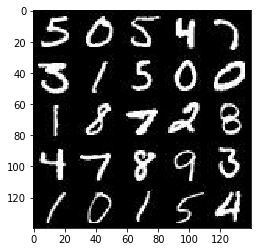

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

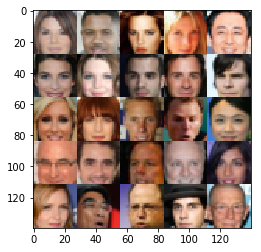

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    placeholder = tf.placeholder(tf.float32, (), name='placeholder')

    return inputs_real, inputs_z, placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
       
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 100 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    _ = show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1590... Generator Loss: 1.2373


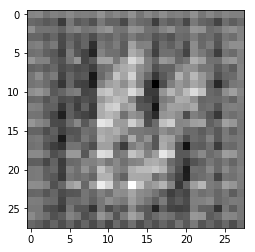

Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 2.7971


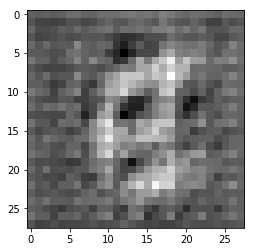

Epoch 1/2... Discriminator Loss: 0.7606... Generator Loss: 1.4547


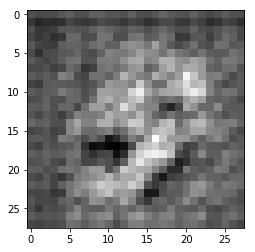

Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 3.5039


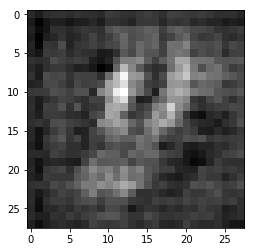

Epoch 1/2... Discriminator Loss: 2.3644... Generator Loss: 4.6233


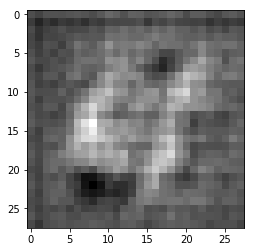

Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 1.0037


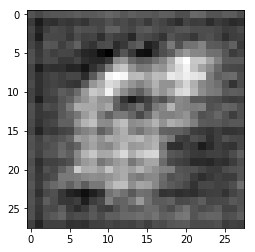

Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.0982


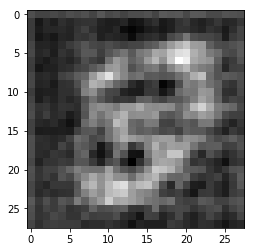

Epoch 1/2... Discriminator Loss: 0.5248... Generator Loss: 2.6043


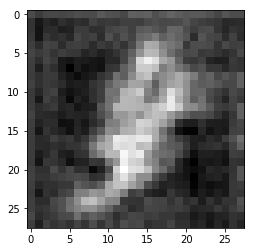

Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.8419


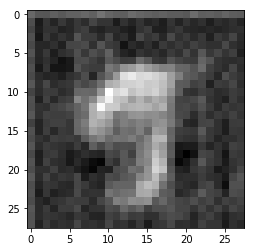

Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 0.8503


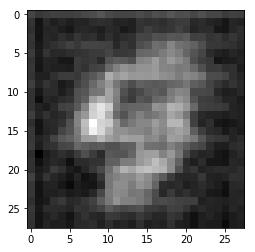

Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.0133


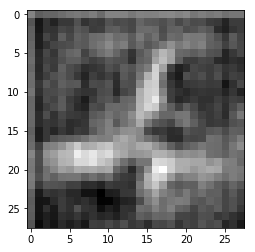

Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 0.8411


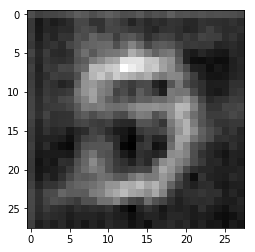

Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 5.6731


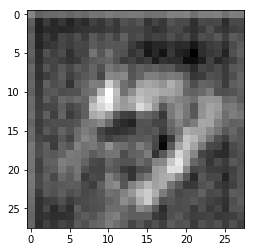

Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.8332


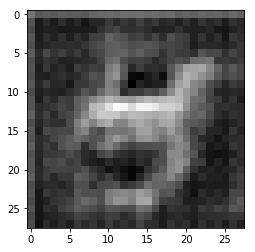

Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.6443


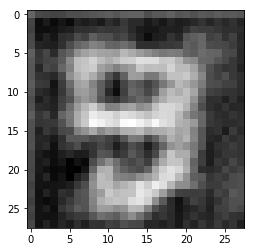

Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 0.6512


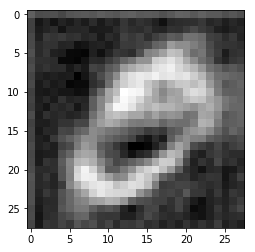

Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 1.0995


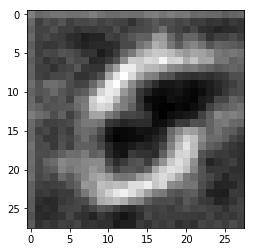

Epoch 1/2... Discriminator Loss: 4.0000... Generator Loss: 0.0536


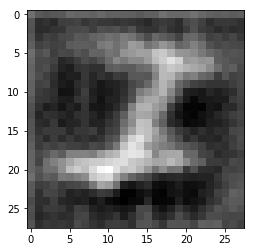

Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.8850


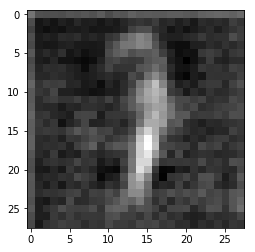

Epoch 1/2... Discriminator Loss: 2.8796... Generator Loss: 0.2264


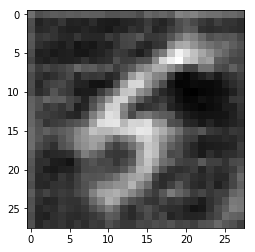

Epoch 1/2... Discriminator Loss: 2.1877... Generator Loss: 0.2312


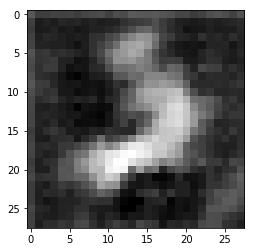

Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 1.9591


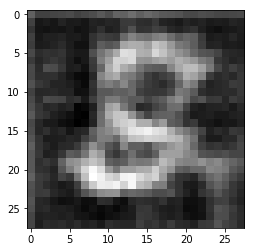

Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.9297


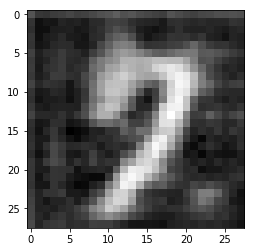

Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.7281


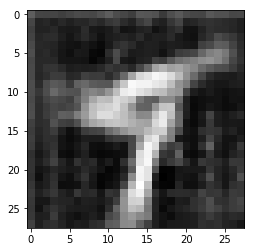

Epoch 1/2... Discriminator Loss: 1.8182... Generator Loss: 0.2995


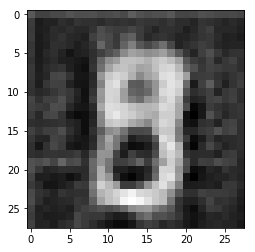

Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.2704


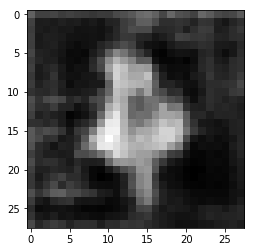

Epoch 1/2... Discriminator Loss: 3.8585... Generator Loss: 6.4201


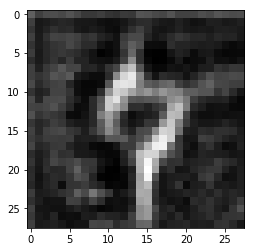

Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.0811


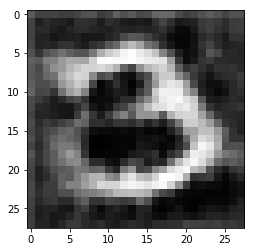

Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 1.4328


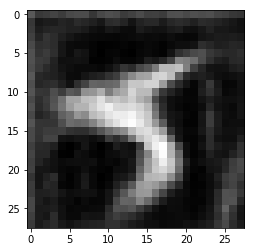

Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.5190


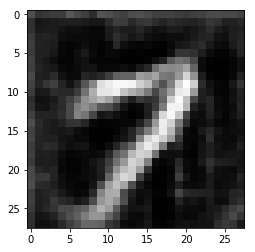

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.9483


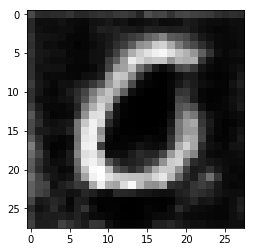

Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 1.0890


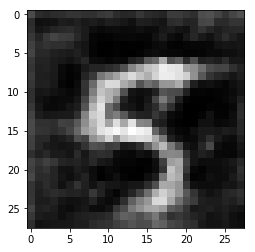

Epoch 1/2... Discriminator Loss: 2.9454... Generator Loss: 0.3181


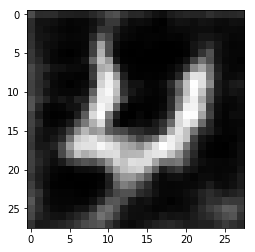

Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.1881


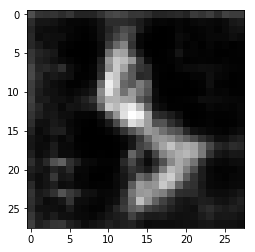

Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.7509


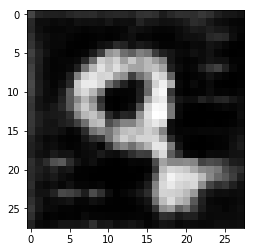

Epoch 1/2... Discriminator Loss: 2.1213... Generator Loss: 0.2895


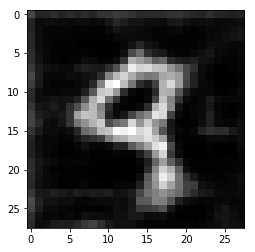

Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.7499


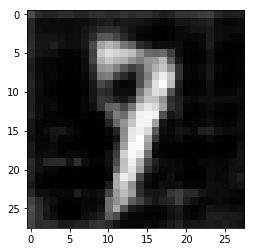

Epoch 2/2... Discriminator Loss: 2.0467... Generator Loss: 0.2871


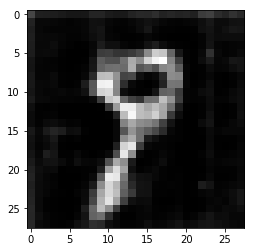

Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 0.8066


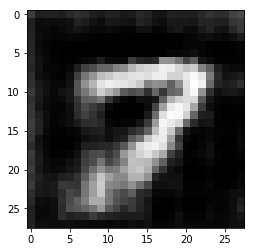

Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 1.4259


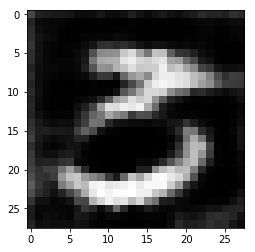

Epoch 2/2... Discriminator Loss: 2.1916... Generator Loss: 0.3487


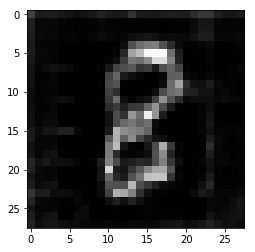

Epoch 2/2... Discriminator Loss: 1.8204... Generator Loss: 0.3230


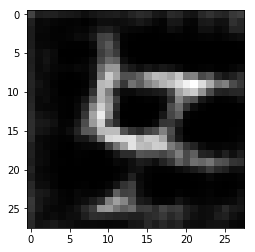

Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.5852


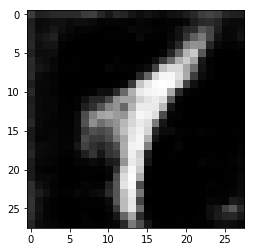

Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 3.6251


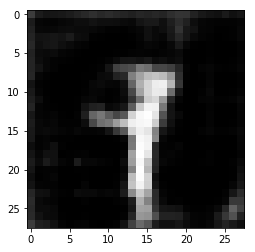

Epoch 2/2... Discriminator Loss: 1.8848... Generator Loss: 0.4573


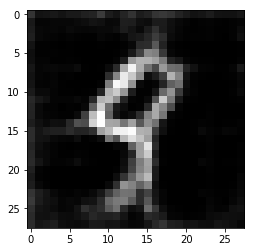

Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.7786


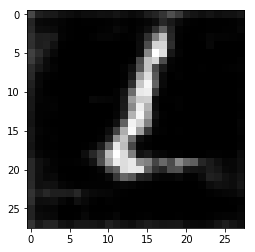

Epoch 2/2... Discriminator Loss: 1.3099... Generator Loss: 0.6757


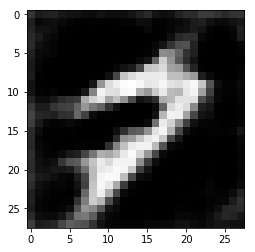

Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 1.2097


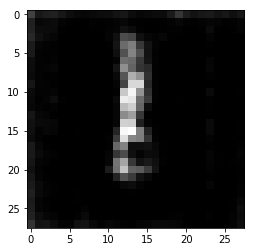

Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.6754


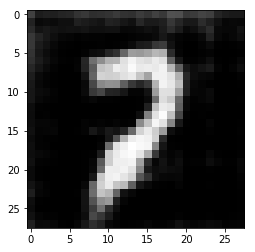

Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.3993


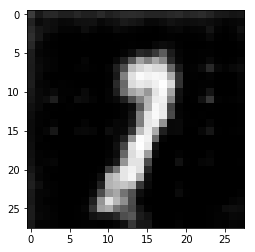

Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.4795


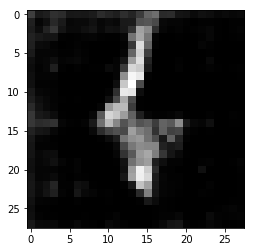

Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 2.7039


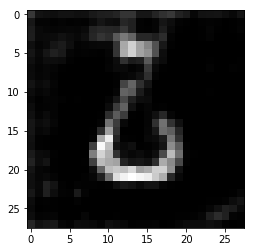

Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.7482


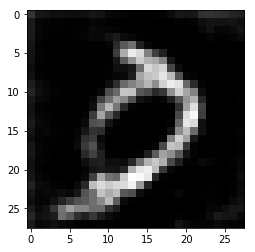

Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.0094


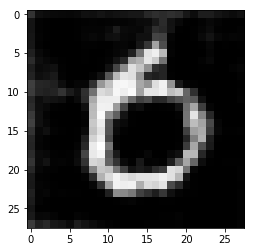

Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.7186


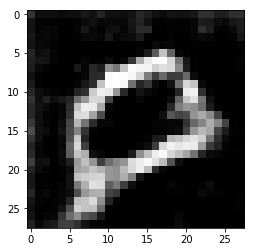

Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 2.1015


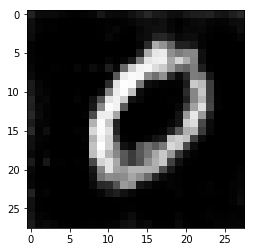

Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 1.0973


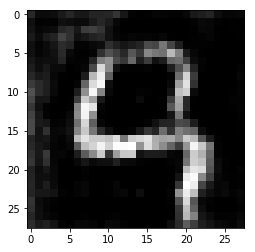

Epoch 2/2... Discriminator Loss: 0.8394... Generator Loss: 1.9692


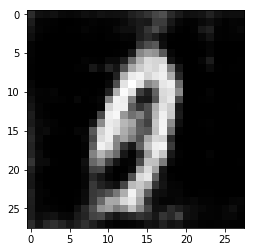

Epoch 2/2... Discriminator Loss: 0.6073... Generator Loss: 3.9370


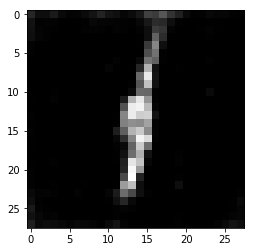

Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.2093


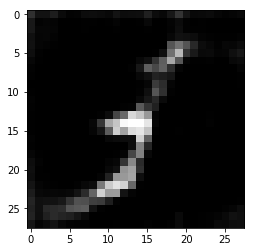

Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.7392


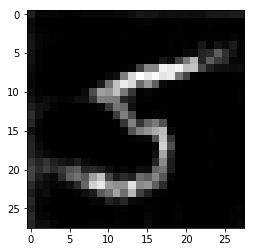

Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.5323


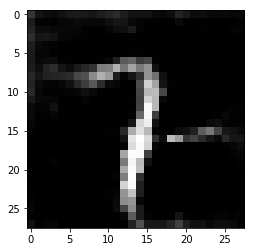

Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.2728


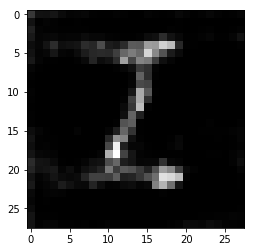

Epoch 2/2... Discriminator Loss: 2.9018... Generator Loss: 0.2333


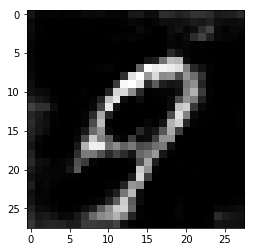

Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 2.0310


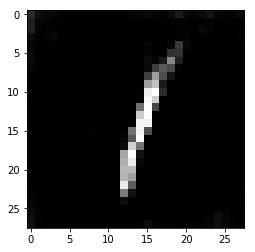

Epoch 2/2... Discriminator Loss: 3.5425... Generator Loss: 0.1247


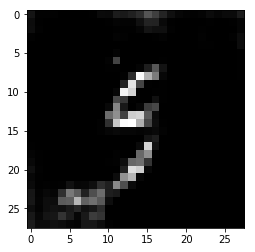

Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.2863


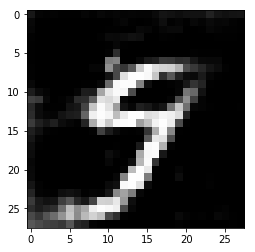

Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 2.4145


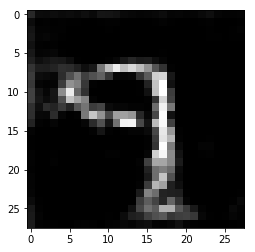

Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 2.0711


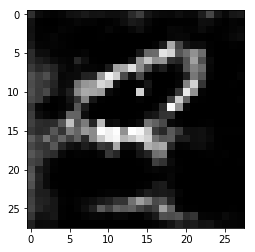

Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 1.4546


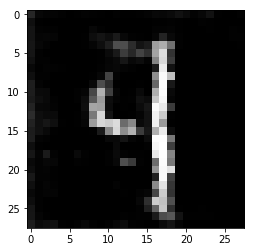

Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 1.1175


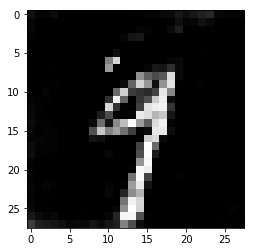

Epoch 2/2... Discriminator Loss: 0.4383... Generator Loss: 3.4347


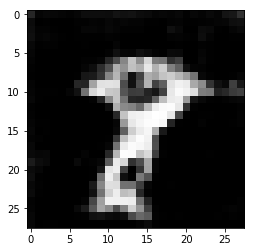

Epoch 2/2... Discriminator Loss: 0.8598... Generator Loss: 1.7269


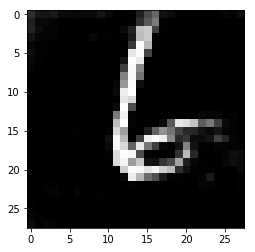

Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.6537


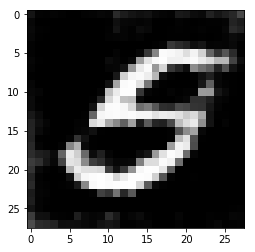

Epoch 2/2... Discriminator Loss: 0.9186... Generator Loss: 1.0424


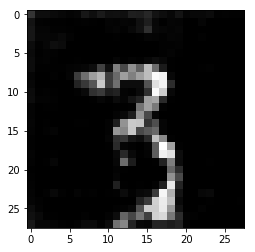

In [12]:
batch_size = 16
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.7264


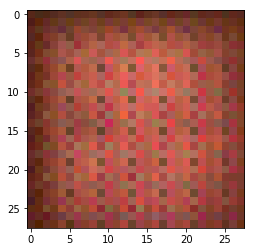

Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.4503


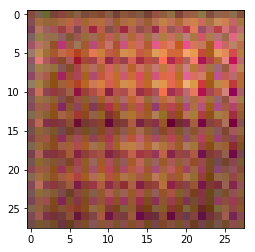

Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 2.7353


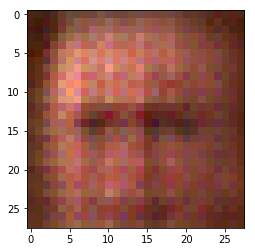

Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.3810


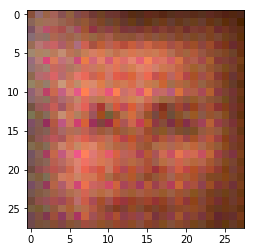

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.0954


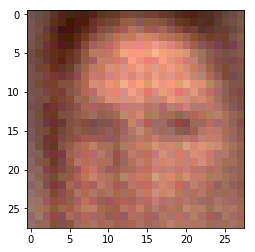

Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4753


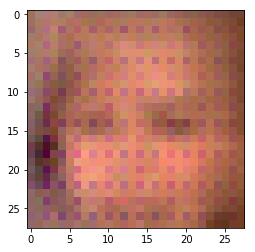

Epoch 1/1... Discriminator Loss: 1.8368... Generator Loss: 0.3225


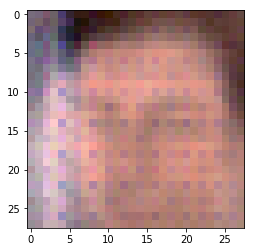

Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.4853


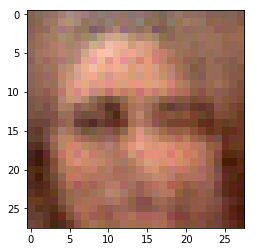

Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6634


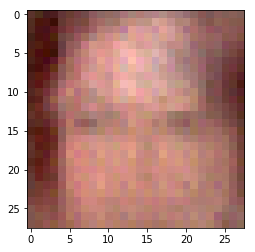

Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.5834


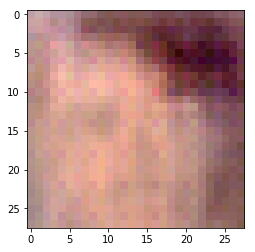

Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.0324


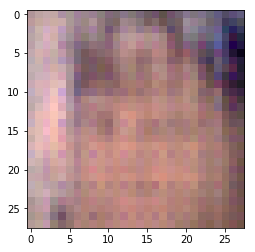

Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.8009


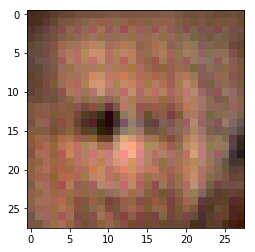

Epoch 1/1... Discriminator Loss: 1.7052... Generator Loss: 0.3787


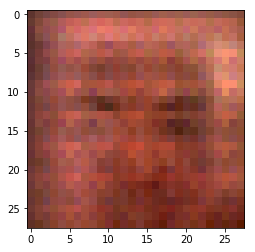

Epoch 1/1... Discriminator Loss: 2.6059... Generator Loss: 0.1551


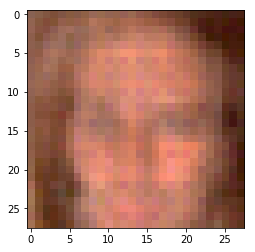

Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8762


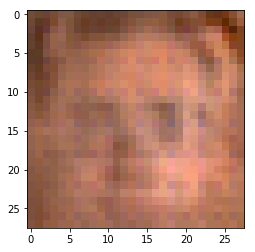

Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.2076


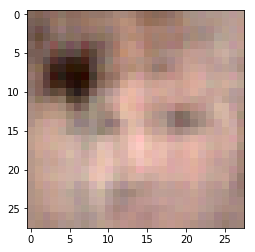

Epoch 1/1... Discriminator Loss: 1.9424... Generator Loss: 2.2293


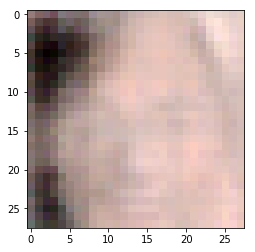

Epoch 1/1... Discriminator Loss: 0.4830... Generator Loss: 2.3984


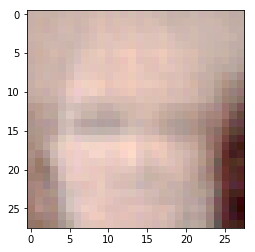

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.9766


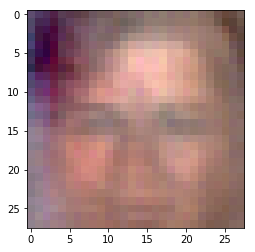

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.4970


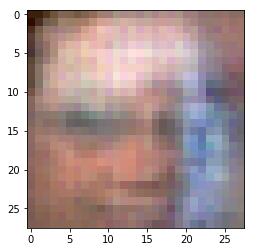

Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.3749


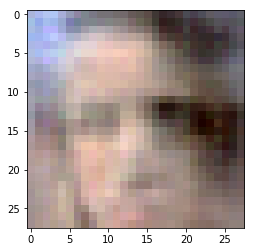

Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.7844


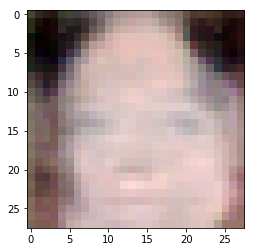

Epoch 1/1... Discriminator Loss: 1.6196... Generator Loss: 0.5887


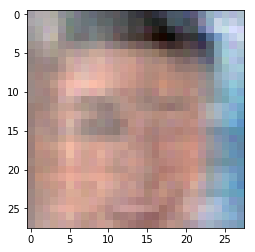

Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 2.7828


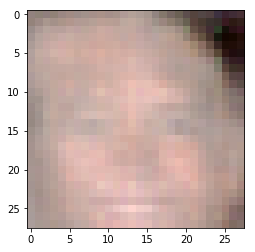

Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.6221


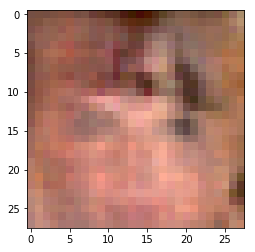

Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 3.1372


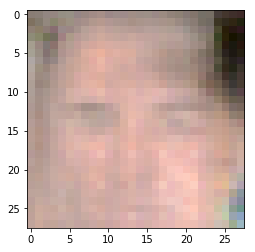

Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 3.7404


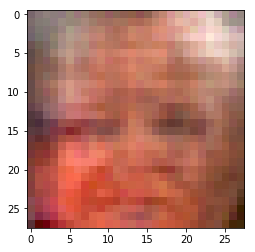

Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.5788


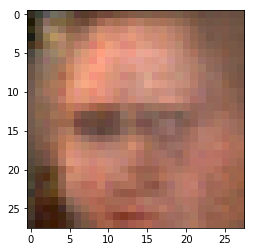

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 4.4188


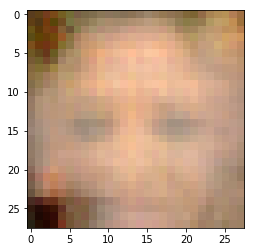

Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.3987


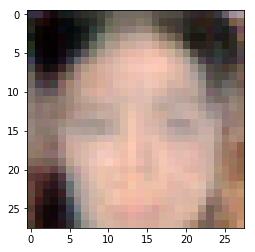

Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.7644


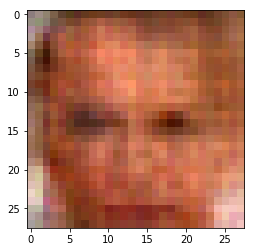

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.